In [2]:
import pandas as pd
import numpy as np
import sklearn
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import datetime
import torch.nn.functional as F
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.classification import BinaryAccuracy
from sklearn.model_selection import train_test_split
import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from torch.nn import BCELoss
import torch.nn.init as init
import random
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [3]:
#Set seeds to allow for reproducibility of the results
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [4]:
#Open the expression data as a pandas data frame
mirna_path = "/home/bettimj/gamazon_rotation/deep_learning_tcga_lc/data/all_common_samples_mirna_scc_ad_combined_no_na.txt"

mirna_file = pd.read_csv(mirna_path, sep = "\t")
mirna_file = mirna_file.sample(frac=1)
mirna_file

,sample,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,...,hsa-mir-941-1,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b,hist
590,TCGA-69-7978-01A,-0.666591,-0.663185,-0.674511,-0.490324,-0.748631,-0.194442,-0.562060,-0.691977,-0.697597,...,-0.126513,-0.484846,-0.468580,-0.284979,-0.368258,-0.804095,-0.622836,-0.732972,-0.233977,ad
278,TCGA-49-AARN-01A,-0.187578,-0.196456,-0.189710,-0.149066,-0.476407,0.251636,-0.089567,-0.276091,-0.263728,...,-0.126513,-0.250808,-0.468580,-0.104186,-0.192294,0.601123,-0.032238,0.267776,0.161825,ad
14,TCGA-05-4410-01A,-0.074787,-0.067787,-0.075724,0.101507,0.090464,-0.130459,-0.176394,-0.197053,-0.190188,...,-0.126513,0.685345,-0.468580,-0.219236,-0.544222,-0.183004,-0.491235,0.197348,-0.219923,ad
678,TCGA-78-7154-01A,-0.007959,-0.012544,-0.008102,-0.412007,-0.499279,-0.525622,0.225478,0.329108,0.315968,...,-0.126513,-0.406833,-0.468580,-0.301415,-0.438644,-0.214059,-0.382103,-0.650471,-0.413059,ad
338,TCGA-55-6970-01A,0.986980,0.983292,0.997317,2.019413,0.078953,2.436969,-0.013147,0.334198,0.342243,...,-0.126513,1.933549,-0.468580,-0.137058,2.587937,1.315378,1.193896,0.383144,0.458622,ad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,TCGA-95-7944-01A,-0.816502,-0.824754,-0.818192,-0.681011,-0.942072,-0.516610,-0.974934,-0.757552,-0.756746,...,-0.126513,0.646339,-0.468580,-0.334286,1.848888,0.368214,-0.792954,-0.960354,-0.485139,ad
192,TCGA-43-8116-01A,-0.318021,-0.329667,-0.320188,-0.513395,1.219466,-0.602201,-0.491047,-0.432977,-0.418381,...,-0.202153,0.964210,3.029515,-0.065644,1.509668,-0.062550,-0.538266,1.223425,-0.500273,scc
629,TCGA-77-7138-01A,0.528765,0.542775,0.530402,1.382113,-0.616685,-0.028819,0.116164,-0.000838,-0.001634,...,-0.202153,0.153191,-0.487547,-0.273168,1.509668,-0.734111,0.441802,-0.665758,-0.462748,scc
559,TCGA-66-2787-01A,-0.891007,-0.887445,-0.895885,-0.891075,-0.790554,-0.953438,-0.859753,-0.890582,-0.894280,...,-0.202153,-0.854439,-0.487547,-0.642253,-0.574265,-0.171678,-1.057507,-0.805896,-0.963885,scc


In [5]:
#Prepare training, validation, and test data

train = mirna_file.iloc[:,1:]
train_features = train.copy()
train_labels = train_features.pop('hist')
train_labels

train_labels = list(map(lambda x: x.replace('ad', '0'), train_labels))
train_labels = list(map(lambda x: x.replace('scc', '1'), train_labels))

train_labels = [int(x) for x in train_labels]
train_labels = np.array(train_labels)

train_labels

train_set_final, test_set_prelim, train_labels_final, test_labels_prelim = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)
val_set_final, test_set_final, val_labels_final, test_labels_final = train_test_split(test_set_prelim, test_labels_prelim, test_size=0.5, random_state=42)

In [6]:
train_set_final = np.array(train_set_final)
train_set_final = torch.tensor(train_set_final, dtype=torch.float32)
train_set_final.shape

train_labels_final = np.array(train_labels_final)
train_labels_final = torch.tensor(train_labels_final, dtype=torch.float32)
train_labels_final.shape

torch.Size([769])

In [7]:
val_set_final = np.array(val_set_final)
val_set_final = torch.tensor(val_set_final, dtype=torch.float32)
val_set_final.shape

val_labels_final = np.array(val_labels_final)
val_labels_final = torch.tensor(val_labels_final, dtype=torch.float32)
val_labels_final.shape

torch.Size([96])

In [8]:
test_set_final = np.array(test_set_final)
test_set_final = torch.tensor(test_set_final, dtype=torch.float32)
test_set_final.shape

torch.Size([97, 1534])

In [9]:
train_features = np.array(train_features)
train_features = torch.tensor(train_features, dtype = torch.float32)

In [10]:
torch.cuda.is_available()

True

In [11]:
#Optimizng convolutional layer parameters
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols + 1

class Net(nn.Module):
    def __init__(self, input_size, conv_num_filters, conv_kernel_size, conv_padding, pool_kernel_size, pool_stride, hidden_size, output_size, num_hidden_layers, activation, batch_size=20):
        super(Net, self).__init__()
        
        self.batch_size = batch_size
        self.conv_num_filters = conv_num_filters
        self.conv_kernel_size = conv_kernel_size
        self.conv_padding = conv_padding
        self.batch_size = batch_size
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride

        # Define the convolutional and max pooling layers
        conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=conv_padding),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        )
        
        # Generate some random input
        z = torch.randn(1, input_shape)
        
        # Pass the input through the convolutional layers
        conv_out = conv_layers(z)
        #print(conv_out.shape)

        # Calculate the number of features in the output of the last convolutional layer
        fc1_in_size = torch.flatten(conv_out, start_dim = 0, end_dim = 1).shape[0]
        self.fc1_in_size = fc1_in_size
        #print("fc1 in size:")
        #print(fc1_in_size)
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=self.conv_padding)
        self.pool1 = nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        
        self.fc1 = nn.Linear(self.fc1_in_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = activation()
    
    def forward(self, x):
        batch_size = x.shape[0]
        out = []
        for i in range(batch_size):
            x_batch = x[i].unsqueeze(0)
            x_batch = self.activation(self.conv1(x_batch))
            x_batch = self.pool1(x_batch)
            #print(x_batch.shape)
            x_batch = torch.flatten(x_batch, start_dim = 0, end_dim = 1)
            #print("x_batch shape:")
            #print(x_batch.shape)
            x_batch = self.activation(self.fc1(x_batch))
            x_batch = torch.sigmoid(self.fc2(x_batch))
            out.append(x_batch.squeeze())
        return torch.stack(out, dim=0)

model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=10,
    module__num_hidden_layers=1,
    module__output_size=1,
    module__activation = nn.ReLU,
    verbose=False,
    device = "cuda",
    callbacks=[
        EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
        EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False)
    ]
)

# Define the grid of model parameters to search over
param_grid = {
    'module__conv_num_filters': [8, 16, 32, 64],
    'module__conv_kernel_size': [3, 5, 7],
    'module__conv_padding': [0, 1, 2],
    'module__pool_kernel_size': [2, 3, 4],
    'module__pool_stride': [1, 2, 3] 
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
X.unsqueeze(0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)

pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/bettimj/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
900 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/bettimj/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/bettimj/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/skorch/classifier.py", line 143, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
  File "/home/bettimj/miniconda3/envs/torch-gpu/lib/python3.10/site-pa

Best: 0.895396 using {'module__conv_kernel_size': 5, 'module__conv_num_filters': 8, 'module__conv_padding': 2, 'module__pool_kernel_size': 4, 'module__pool_stride': 3}
nan (nan) with: {'module__conv_kernel_size': 3, 'module__conv_num_filters': 8, 'module__conv_padding': 0, 'module__pool_kernel_size': 2, 'module__pool_stride': 1}
0.666162 (0.206039) with: {'module__conv_kernel_size': 3, 'module__conv_num_filters': 8, 'module__conv_padding': 0, 'module__pool_kernel_size': 2, 'module__pool_stride': 2}
0.685742 (0.230595) with: {'module__conv_kernel_size': 3, 'module__conv_num_filters': 8, 'module__conv_padding': 0, 'module__pool_kernel_size': 2, 'module__pool_stride': 3}
nan (nan) with: {'module__conv_kernel_size': 3, 'module__conv_num_filters': 8, 'module__conv_padding': 0, 'module__pool_kernel_size': 3, 'module__pool_stride': 1}
nan (nan) with: {'module__conv_kernel_size': 3, 'module__conv_num_filters': 8, 'module__conv_padding': 0, 'module__pool_kernel_size': 3, 'module__pool_stride': 

In [12]:
#Optimizng number of convolutional layers
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols + 1

input_size=input_shape
hidden_size=10
num_hidden_layers=1
output_size=1,
activation=nn.ReLU
conv_kernel_size=5
conv_num_filters=8
conv_padding=2
pool_kernel_size=4
pool_stride=3

class Net(nn.Module):
    def __init__(self, input_size, conv_layers, conv_num_filters, conv_kernel_size, conv_padding, pool_kernel_size, pool_stride, hidden_size, output_size, num_hidden_layers, activation, batch_size=20):
        super(Net, self).__init__()
        
        self.batch_size = batch_size
        self.conv_layers = conv_layers
        self.conv_num_filters = conv_num_filters
        self.conv_kernel_size = conv_kernel_size
        self.conv_padding = conv_padding
        self.batch_size = batch_size
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride

        # Define the convolutional and max pooling layers
        self.conv_layers = conv_layers
        
        # Generate some random input
        z = torch.randn(1, input_shape)
        
        # Pass the input through the convolutional layers
        conv_out = self.conv_layers(z)
        #print(conv_out.shape)

        # Calculate the number of features in the output of the last convolutional layer
        fc1_in_size = torch.flatten(conv_out, start_dim = 0, end_dim = 1).shape[0]
        self.fc1_in_size = fc1_in_size
        #print("fc1 in size:")
        #print(fc1_in_size)
        
        self.fc1 = nn.Linear(self.fc1_in_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = activation()
    
    def forward(self, x):
        batch_size = x.shape[0]
        out = []
        for i in range(batch_size):
            x_batch = x[i].unsqueeze(0)
            x_batch = self.conv_layers(x_batch)
            #print(x_batch.shape)
            x_batch = torch.flatten(x_batch, start_dim = 0, end_dim = 1)
            #print("x_batch shape:")
            #print(x_batch.shape)
            x_batch = self.activation(self.fc1(x_batch))
            x_batch = torch.sigmoid(self.fc2(x_batch))
            out.append(x_batch.squeeze())
        return torch.stack(out, dim=0)

model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=10,
    module__num_hidden_layers=1,
    module__output_size=1,
    module__activation=nn.ReLU,
    module__conv_kernel_size=5,
    module__conv_num_filters=8,
    module__conv_padding=2,
    module__pool_kernel_size=4,
    module__pool_stride=3,
    verbose=False,
    device = "cuda",
    callbacks=[
        EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
        EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False)
    ]
)

# Define the grid of model parameters to search over
param_grid = {
    'module__conv_layers': [
        nn.Sequential(
            activation(nn.Conv1d(in_channels=1, out_channels=conv_num_filters, kernel_size=conv_kernel_size, padding=conv_padding)),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        ),
        nn.Sequential(
            activation(nn.Conv1d(in_channels=1, out_channels=conv_num_filters, kernel_size=conv_kernel_size, padding=conv_padding)),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride)),
            activation(nn.Conv1d(in_channels=conv_num_filters, out_channels=2*conv_num_filters, kernel_size=conv_kernel_size, padding=conv_padding)),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        ),
        nn.Sequential(
            activation(nn.Conv1d(in_channels=1, out_channels=conv_num_filters, kernel_size=conv_kernel_size, padding=conv_padding)),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride)),
            activation(nn.Conv1d(in_channels=conv_num_filters, out_channels=2*conv_num_filters, kernel_size=conv_kernel_size, padding=conv_padding)),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride)),
            activation(nn.Conv1d(in_channels=2*conv_num_filters, out_channels=3*conv_num_filters, kernel_size=conv_kernel_size, padding=conv_padding)),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        ),
        nn.Sequential(
            activation(nn.Conv1d(in_channels=1, out_channels=conv_num_filters, kernel_size=conv_kernel_size, padding=conv_padding)),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride)),
            activation(nn.Conv1d(in_channels=conv_num_filters, out_channels=2*conv_num_filters, kernel_size=conv_kernel_size, padding=conv_padding)),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride)),
            activation(nn.Conv1d(in_channels=2*conv_num_filters, out_channels=3*conv_num_filters, kernel_size=conv_kernel_size, padding=conv_padding)),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride)),
            activation(nn.Conv1d(in_channels=3*conv_num_filters, out_channels=4*conv_num_filters, kernel_size=conv_kernel_size, padding=conv_padding)),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        ),
        nn.Sequential(
            activation(nn.Conv1d(in_channels=1, out_channels=conv_num_filters, kernel_size=conv_kernel_size, padding=conv_padding)),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride)),
            activation(nn.Conv1d(in_channels=conv_num_filters, out_channels=2*conv_num_filters, kernel_size=conv_kernel_size, padding=conv_padding)),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride)),
            activation(nn.Conv1d(in_channels=2*conv_num_filters, out_channels=3*conv_num_filters, kernel_size=conv_kernel_size, padding=conv_padding)),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride)),
            activation(nn.Conv1d(in_channels=3*conv_num_filters, out_channels=4*conv_num_filters, kernel_size=conv_kernel_size, padding=conv_padding)),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride)),
            activation(nn.Conv1d(in_channels=4*conv_num_filters, out_channels=5*conv_num_filters, kernel_size=conv_kernel_size, padding=conv_padding)),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        )
    ]
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
X.unsqueeze(0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best: 0.630698 using {'module__conv_layers': Sequential(
  (0): ReLU(
    inplace=True
    (inplace): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (1): MaxPool1d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
)}
0.630698 (0.010822) with: {'module__conv_layers': Sequential(
  (0): ReLU(
    inplace=True
    (inplace): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (1): MaxPool1d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
)}
0.508004 (0.010264) with: {'module__conv_layers': Sequential(
  (0): ReLU(
    inplace=True
    (inplace): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (1): MaxPool1d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU(
    inplace=True
    (inplace): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (3): MaxPool1d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=Fal

In [10]:
#Optimizng the activation function of the convolutional layer
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols + 1

class Net(nn.Module):
    def __init__(self, input_size, conv_num_filters, conv_kernel_size, conv_padding, conv_activation, pool_kernel_size, pool_stride, hidden_size, output_size, num_hidden_layers, hidden_activation, batch_size=20):
        super(Net, self).__init__()
        
        self.batch_size = batch_size
        self.conv_num_filters = conv_num_filters
        self.conv_kernel_size = conv_kernel_size
        self.conv_padding = conv_padding
        self.batch_size = batch_size
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride

        # Define the convolutional and max pooling layers
        conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=conv_padding),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        )
        
        # Generate some random input
        z = torch.randn(1, input_shape)
        
        # Pass the input through the convolutional layers
        conv_out = conv_layers(z)
        #print(conv_out.shape)

        # Calculate the number of features in the output of the last convolutional layer
        fc1_in_size = torch.flatten(conv_out, start_dim = 0, end_dim = 1).shape[0]
        self.fc1_in_size = fc1_in_size
        #print("fc1 in size:")
        #print(fc1_in_size)
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=self.conv_padding)
        self.pool1 = nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        
        self.fc1 = nn.Linear(self.fc1_in_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
        self.conv_activation = conv_activation()
        self.hidden_activation = hidden_activation()
    
    def forward(self, x):
        batch_size = x.shape[0]
        out = []
        for i in range(batch_size):
            x_batch = x[i].unsqueeze(0)
            x_batch = self.conv_activation(self.conv1(x_batch))
            x_batch = self.pool1(x_batch)
            #print(x_batch.shape)
            x_batch = torch.flatten(x_batch, start_dim = 0, end_dim = 1)
            #print("x_batch shape:")
            #print(x_batch.shape)
            x_batch = self.hidden_activation(self.fc1(x_batch))
            x_batch = torch.sigmoid(self.fc2(x_batch))
            out.append(x_batch.squeeze())
        return torch.stack(out, dim=0)

model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=10,
    module__num_hidden_layers=1,
    module__output_size=1,
    module__hidden_activation=nn.ReLU,
    module__conv_kernel_size=5,
    module__conv_num_filters=8,
    module__conv_padding=2,
    module__pool_kernel_size=4,
    module__pool_stride=3,
    verbose=False,
    device = "cuda",
    callbacks=[
        EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
        EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False)
    ]
)

# Define the grid of model parameters to search over
param_grid = {
    'module__conv_activation': [nn.Identity, nn.ReLU, nn.LeakyReLU, nn.ELU, nn.ReLU6,
                          nn.GELU, nn.Softplus, nn.Softsign, nn.Tanh,
                          nn.Sigmoid, nn.Hardsigmoid] 
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
X.unsqueeze(0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best: 0.836699 using {'module__conv_activation': <class 'torch.nn.modules.activation.ReLU'>}
0.712821 (0.176992) with: {'module__conv_activation': <class 'torch.nn.modules.linear.Identity'>}
0.836699 (0.171733) with: {'module__conv_activation': <class 'torch.nn.modules.activation.ReLU'>}
0.777793 (0.227341) with: {'module__conv_activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
0.828016 (0.171462) with: {'module__conv_activation': <class 'torch.nn.modules.activation.ELU'>}
0.679380 (0.219708) with: {'module__conv_activation': <class 'torch.nn.modules.activation.ReLU6'>}
0.809548 (0.160218) with: {'module__conv_activation': <class 'torch.nn.modules.activation.GELU'>}
0.498810 (0.002381) with: {'module__conv_activation': <class 'torch.nn.modules.activation.Softplus'>}
0.793255 (0.239692) with: {'module__conv_activation': <class 'torch.nn.modules.activation.Softsign'>}
0.500000 (0.000000) with: {'module__conv_activati

In [12]:
#Optimizng the number of neurons in each hidden layer - starting network has one hidden layer
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, conv_num_filters, conv_kernel_size, conv_padding, conv_activation, pool_kernel_size, pool_stride, hidden_size, output_size, num_hidden_layers, hidden_activation, batch_size=20):
        super(Net, self).__init__()
        
        self.batch_size = batch_size
        self.conv_num_filters = conv_num_filters
        self.conv_kernel_size = conv_kernel_size
        self.conv_padding = conv_padding
        self.batch_size = batch_size
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride

        # Define the convolutional and max pooling layers
        conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=conv_padding),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        )
        
        # Generate some random input
        z = torch.randn(1, input_shape)
        
        # Pass the input through the convolutional layers
        conv_out = conv_layers(z)
        #print(conv_out.shape)

        # Calculate the number of features in the output of the last convolutional layer
        fc1_in_size = torch.flatten(conv_out, start_dim = 0, end_dim = 1).shape[0]
        self.fc1_in_size = fc1_in_size
        #print("fc1 in size:")
        #print(fc1_in_size)
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=self.conv_padding)
        self.pool1 = nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        
        self.fc1 = nn.Linear(self.fc1_in_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
        self.conv_activation = conv_activation()
        self.hidden_activation = hidden_activation()
    
    def forward(self, x):
        batch_size = x.shape[0]
        out = []
        for i in range(batch_size):
            x_batch = x[i].unsqueeze(0)
            x_batch = self.conv_activation(self.conv1(x_batch))
            x_batch = self.pool1(x_batch)
            #print(x_batch.shape)
            x_batch = torch.flatten(x_batch, start_dim = 0, end_dim = 1)
            #print("x_batch shape:")
            #print(x_batch.shape)
            x_batch = self.hidden_activation(self.fc1(x_batch))
            x_batch = torch.sigmoid(self.fc2(x_batch))
            out.append(x_batch.squeeze())
        return torch.stack(out, dim=0)

model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__num_hidden_layers=1,
    module__output_size=1,
    module__conv_activation=nn.ReLU,
    module__hidden_activation=nn.ReLU,
    module__conv_kernel_size=5,
    module__conv_num_filters=8,
    module__conv_padding=2,
    module__pool_kernel_size=4,
    module__pool_stride=3,
    verbose=False,
    device = "cuda",
    callbacks=[
        EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
        EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False)
    ]
)

# Define the grid of model parameters to search over
param_grid = {
    'module__hidden_size': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best: 0.921939 using {'module__hidden_size': 50}
0.693393 (0.236487) with: {'module__hidden_size': 10}
0.820657 (0.161759) with: {'module__hidden_size': 20}
0.898349 (0.024199) with: {'module__hidden_size': 30}
0.741400 (0.202074) with: {'module__hidden_size': 40}
0.921939 (0.045206) with: {'module__hidden_size': 50}
0.778560 (0.153685) with: {'module__hidden_size': 60}
0.809979 (0.158440) with: {'module__hidden_size': 70}
0.827135 (0.168944) with: {'module__hidden_size': 80}
0.706856 (0.176125) with: {'module__hidden_size': 90}
0.767883 (0.159939) with: {'module__hidden_size': 100}


In [11]:
#Optimizng the number hidden layers - starting network has one hidden layer, so the actual number of hidden layers in grid search models is module__num_hidden_layers + 1
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, conv_num_filters, conv_kernel_size, conv_padding, conv_activation, pool_kernel_size, pool_stride, hidden_size, output_size, num_hidden_layers, hidden_activation, batch_size=20):
        super(Net, self).__init__()
        
        self.batch_size = batch_size
        self.conv_num_filters = conv_num_filters
        self.conv_kernel_size = conv_kernel_size
        self.conv_padding = conv_padding
        self.batch_size = batch_size
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride

        # Define the convolutional and max pooling layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=conv_padding),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        )
        
        # Generate some random input
        z = torch.randn(1, input_shape)
        
        # Pass the input through the convolutional layers
        conv_out = self.conv_layers(z)
        #print(conv_out.shape)

        # Calculate the number of features in the output of the last convolutional layer
        fc1_in_size = torch.flatten(conv_out, start_dim = 0, end_dim = 1).shape[0]
        self.fc1_in_size = fc1_in_size
        #print("fc1 in size:")
        #print(fc1_in_size)
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=self.conv_padding)
        self.pool1 = nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        
        # Define the fully connected layers
        self.fc_layers = nn.ModuleList()
        for i in range(num_hidden_layers):
            if i == 0:
                self.fc_layers.append(nn.Linear(self.fc1_in_size, hidden_size))
            else:
                self.fc_layers.append(nn.Linear(hidden_size, hidden_size))
        self.fc_layers.append(nn.Linear(hidden_size, output_size))
        
        self.conv_activation = conv_activation()
        self.hidden_activation = hidden_activation()
    
    def forward(self, x):
        batch_size = x.shape[0]
        out = []
        for i in range(batch_size):
            x_batch = x[i].unsqueeze(0)
            x_batch = self.conv_activation(self.conv1(x_batch))
            x_batch = self.pool1(x_batch)
            #print(x_batch.shape)
            x_batch = torch.flatten(x_batch, start_dim = 0, end_dim = 1)
            #print("x_batch shape:")
            #print(x_batch.shape)
            for fc_layer in self.fc_layers[:-1]:
                x_batch = self.hidden_activation(fc_layer(x_batch))
            x_batch = torch.sigmoid(self.fc_layers[-1](x_batch))
            out.append(x_batch.squeeze())
        return torch.stack(out, dim=0)

model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=50,
    module__output_size=1,
    module__conv_activation=nn.ReLU,
    module__hidden_activation=nn.ReLU,
    module__conv_kernel_size=5,
    module__conv_num_filters=8,
    module__conv_padding=2,
    module__pool_kernel_size=4,
    module__pool_stride=3,
    verbose=False,
    device = "cuda",
    callbacks=[
        EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
        EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False)
    ]
)

# Define the grid of model parameters to search over
param_grid = {
    'module__num_hidden_layers': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best: 0.984854 using {'module__num_hidden_layers': 6}
0.887692 (0.100949) with: {'module__num_hidden_layers': 1}
0.819648 (0.169572) with: {'module__num_hidden_layers': 2}
0.829196 (0.169073) with: {'module__num_hidden_layers': 3}
0.920681 (0.053231) with: {'module__num_hidden_layers': 4}
0.958495 (0.028751) with: {'module__num_hidden_layers': 5}
0.984854 (0.010509) with: {'module__num_hidden_layers': 6}
0.948540 (0.048319) with: {'module__num_hidden_layers': 7}
0.868540 (0.185075) with: {'module__num_hidden_layers': 8}
0.803763 (0.181394) with: {'module__num_hidden_layers': 9}
0.784966 (0.235459) with: {'module__num_hidden_layers': 10}


In [13]:
#Optimizng the batch size and number of epochs
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, conv_num_filters, conv_kernel_size, conv_padding, conv_activation, pool_kernel_size, pool_stride, hidden_size, output_size, num_hidden_layers, hidden_activation, batch_size=20):
        super(Net, self).__init__()
        
        self.batch_size = batch_size
        self.conv_num_filters = conv_num_filters
        self.conv_kernel_size = conv_kernel_size
        self.conv_padding = conv_padding
        self.batch_size = batch_size
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride

        # Define the convolutional and max pooling layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=conv_padding),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        )
        
        # Generate some random input
        z = torch.randn(1, input_shape)
        
        # Pass the input through the convolutional layers
        conv_out = self.conv_layers(z)
        #print(conv_out.shape)

        # Calculate the number of features in the output of the last convolutional layer
        fc1_in_size = torch.flatten(conv_out, start_dim = 0, end_dim = 1).shape[0]
        self.fc1_in_size = fc1_in_size
        #print("fc1 in size:")
        #print(fc1_in_size)
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=self.conv_padding)
        self.pool1 = nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        
        # Define the fully connected layers
        self.fc_layers = nn.ModuleList()
        for i in range(num_hidden_layers):
            if i == 0:
                self.fc_layers.append(nn.Linear(self.fc1_in_size, hidden_size))
            else:
                self.fc_layers.append(nn.Linear(hidden_size, hidden_size))
        self.fc_layers.append(nn.Linear(hidden_size, output_size))
        
        self.conv_activation = conv_activation()
        self.hidden_activation = hidden_activation()
    
    def forward(self, x):
        batch_size = x.shape[0]
        out = []
        for i in range(batch_size):
            x_batch = x[i].unsqueeze(0)
            x_batch = self.conv_activation(self.conv1(x_batch))
            x_batch = self.pool1(x_batch)
            #print(x_batch.shape)
            x_batch = torch.flatten(x_batch, start_dim = 0, end_dim = 1)
            #print("x_batch shape:")
            #print(x_batch.shape)
            for fc_layer in self.fc_layers[:-1]:
                x_batch = self.hidden_activation(fc_layer(x_batch))
            x_batch = torch.sigmoid(self.fc_layers[-1](x_batch))
            out.append(x_batch.squeeze())
        return torch.stack(out, dim=0)

model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=50,
    module__num_hidden_layers=6,
    module__output_size=1,
    module__conv_activation=nn.ReLU,
    module__hidden_activation=nn.ReLU,
    module__conv_kernel_size=5,
    module__conv_num_filters=8,
    module__conv_padding=2,
    module__pool_kernel_size=4,
    module__pool_stride=3,
    verbose=False,
    device = "cuda",
    callbacks=[
        EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
        EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False)
    ]
)

# Define the grid of model parameters to search over
param_grid = {
    'batch_size':[10, 20, 40, 60, 80, 100],
    'max_epochs': [10, 20, 30, 40, 50],
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best: 0.943342 using {'batch_size': 40, 'max_epochs': 30}
0.626789 (0.195076) with: {'batch_size': 10, 'max_epochs': 10}
0.601070 (0.199343) with: {'batch_size': 10, 'max_epochs': 20}
0.600000 (0.200000) with: {'batch_size': 10, 'max_epochs': 30}
0.598435 (0.196870) with: {'batch_size': 10, 'max_epochs': 40}
0.593498 (0.192360) with: {'batch_size': 10, 'max_epochs': 50}
0.778469 (0.219451) with: {'batch_size': 20, 'max_epochs': 10}
0.786726 (0.234332) with: {'batch_size': 20, 'max_epochs': 20}
0.895495 (0.197884) with: {'batch_size': 20, 'max_epochs': 30}
0.700452 (0.243218) with: {'batch_size': 20, 'max_epochs': 40}
0.883166 (0.191846) with: {'batch_size': 20, 'max_epochs': 50}
0.771033 (0.189738) with: {'batch_size': 40, 'max_epochs': 10}
0.865793 (0.184821) with: {'batch_size': 40, 'max_epochs': 20}
0.943342 (0.031297) with: {'batch_size': 40, 'max_epochs': 30}
0.834038 (0.169128) with: {'batch_size': 40, 'max_epochs': 40

In [14]:
#Optimizng the training optimization algorithm
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, conv_num_filters, conv_kernel_size, conv_padding, conv_activation, pool_kernel_size, pool_stride, hidden_size, output_size, num_hidden_layers, hidden_activation, batch_size=20):
        super(Net, self).__init__()
        
        self.batch_size = batch_size
        self.conv_num_filters = conv_num_filters
        self.conv_kernel_size = conv_kernel_size
        self.conv_padding = conv_padding
        self.batch_size = batch_size
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride

        # Define the convolutional and max pooling layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=conv_padding),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        )
        
        # Generate some random input
        z = torch.randn(1, input_shape)
        
        # Pass the input through the convolutional layers
        conv_out = self.conv_layers(z)
        #print(conv_out.shape)

        # Calculate the number of features in the output of the last convolutional layer
        fc1_in_size = torch.flatten(conv_out, start_dim = 0, end_dim = 1).shape[0]
        self.fc1_in_size = fc1_in_size
        #print("fc1 in size:")
        #print(fc1_in_size)
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=self.conv_padding)
        self.pool1 = nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        
        # Define the fully connected layers
        self.fc_layers = nn.ModuleList()
        for i in range(num_hidden_layers):
            if i == 0:
                self.fc_layers.append(nn.Linear(self.fc1_in_size, hidden_size))
            else:
                self.fc_layers.append(nn.Linear(hidden_size, hidden_size))
        self.fc_layers.append(nn.Linear(hidden_size, output_size))
        
        self.conv_activation = conv_activation()
        self.hidden_activation = hidden_activation()
    
    def forward(self, x):
        batch_size = x.shape[0]
        out = []
        for i in range(batch_size):
            x_batch = x[i].unsqueeze(0)
            x_batch = self.conv_activation(self.conv1(x_batch))
            x_batch = self.pool1(x_batch)
            #print(x_batch.shape)
            x_batch = torch.flatten(x_batch, start_dim = 0, end_dim = 1)
            #print("x_batch shape:")
            #print(x_batch.shape)
            for fc_layer in self.fc_layers[:-1]:
                x_batch = self.hidden_activation(fc_layer(x_batch))
            x_batch = torch.sigmoid(self.fc_layers[-1](x_batch))
            out.append(x_batch.squeeze())
        return torch.stack(out, dim=0)

model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    #optimizer=optim.Adam,
    max_epochs=30,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=50,
    module__num_hidden_layers=6,
    module__output_size=1,
    module__conv_activation=nn.ReLU,
    module__hidden_activation=nn.ReLU,
    module__conv_kernel_size=5,
    module__conv_num_filters=8,
    module__conv_padding=2,
    module__pool_kernel_size=4,
    module__pool_stride=3,
    verbose=False,
    device = "cuda",
    callbacks=[
        EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
        EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False)
    ]
)

# Define the grid of model parameters to search over
param_grid = {
    'optimizer':[optim.SGD, optim.RMSprop, optim.Adagrad, optim.Adadelta,
                  optim.Adam, optim.Adamax, optim.NAdam]
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best: 0.932468 using {'optimizer': <class 'torch.optim.adam.Adam'>}
0.518239 (0.026368) with: {'optimizer': <class 'torch.optim.sgd.SGD'>}
0.500000 (0.000000) with: {'optimizer': <class 'torch.optim.rmsprop.RMSprop'>}
0.731877 (0.077640) with: {'optimizer': <class 'torch.optim.adagrad.Adagrad'>}
0.499679 (0.051529) with: {'optimizer': <class 'torch.optim.adadelta.Adadelta'>}
0.932468 (0.040979) with: {'optimizer': <class 'torch.optim.adam.Adam'>}
0.862753 (0.066902) with: {'optimizer': <class 'torch.optim.adamax.Adamax'>}
0.638930 (0.195205) with: {'optimizer': <class 'torch.optim.nadam.NAdam'>}


In [16]:
#Optimizng the learning rate and momentum
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, conv_num_filters, conv_kernel_size, conv_padding, conv_activation, pool_kernel_size, pool_stride, hidden_size, output_size, num_hidden_layers, hidden_activation, batch_size=20):
        super(Net, self).__init__()
        
        self.batch_size = batch_size
        self.conv_num_filters = conv_num_filters
        self.conv_kernel_size = conv_kernel_size
        self.conv_padding = conv_padding
        self.batch_size = batch_size
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride

        # Define the convolutional and max pooling layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=conv_padding),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        )
        
        # Generate some random input
        z = torch.randn(1, input_shape)
        
        # Pass the input through the convolutional layers
        conv_out = self.conv_layers(z)
        #print(conv_out.shape)

        # Calculate the number of features in the output of the last convolutional layer
        fc1_in_size = torch.flatten(conv_out, start_dim = 0, end_dim = 1).shape[0]
        self.fc1_in_size = fc1_in_size
        #print("fc1 in size:")
        #print(fc1_in_size)
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=self.conv_padding)
        self.pool1 = nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        
        # Define the fully connected layers
        self.fc_layers = nn.ModuleList()
        for i in range(num_hidden_layers):
            if i == 0:
                self.fc_layers.append(nn.Linear(self.fc1_in_size, hidden_size))
            else:
                self.fc_layers.append(nn.Linear(hidden_size, hidden_size))
        self.fc_layers.append(nn.Linear(hidden_size, output_size))
        
        self.conv_activation = conv_activation()
        self.hidden_activation = hidden_activation()
    
    def forward(self, x):
        batch_size = x.shape[0]
        out = []
        for i in range(batch_size):
            x_batch = x[i].unsqueeze(0)
            x_batch = self.conv_activation(self.conv1(x_batch))
            x_batch = self.pool1(x_batch)
            #print(x_batch.shape)
            x_batch = torch.flatten(x_batch, start_dim = 0, end_dim = 1)
            #print("x_batch shape:")
            #print(x_batch.shape)
            for fc_layer in self.fc_layers[:-1]:
                x_batch = self.hidden_activation(fc_layer(x_batch))
            x_batch = torch.sigmoid(self.fc_layers[-1](x_batch))
            out.append(x_batch.squeeze())
        return torch.stack(out, dim=0)

model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.Adam,
    max_epochs=30,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=50,
    module__num_hidden_layers=6,
    module__output_size=1,
    module__conv_activation=nn.ReLU,
    module__hidden_activation=nn.ReLU,
    module__conv_kernel_size=5,
    module__conv_num_filters=8,
    module__conv_padding=2,
    module__pool_kernel_size=4,
    module__pool_stride=3,
    verbose=False,
    device = "cuda",
    callbacks=[
        EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
        EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False)
    ]
)

# Define the grid of model parameters to search over
param_grid = {
    'optimizer__lr': [0.0001, 0.0005 ,0.001, 0.005, 0.01, 0.1, 0.2, 0.3],
    #'optimizer__momentum': [0.0, 0.2, 0.4, 0.6, 0.8, 0.9],
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best: 0.941795 using {'optimizer__lr': 0.01}
0.732139 (0.086710) with: {'optimizer__lr': 0.0001}
0.766576 (0.032287) with: {'optimizer__lr': 0.0005}
0.747437 (0.080556) with: {'optimizer__lr': 0.001}
0.893853 (0.053766) with: {'optimizer__lr': 0.005}
0.941795 (0.032321) with: {'optimizer__lr': 0.01}
0.500000 (0.000000) with: {'optimizer__lr': 0.1}
0.500000 (0.000000) with: {'optimizer__lr': 0.2}
0.500000 (0.000000) with: {'optimizer__lr': 0.3}


In [21]:
#Optimizng how the weights are initialized
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, conv_num_filters, conv_kernel_size, conv_padding, conv_activation, pool_kernel_size, pool_stride, hidden_size, output_size, num_hidden_layers, hidden_activation, weight_init_conv, weight_init_hidden, weight_init_out, batch_size=20):
        super(Net, self).__init__()
        
        self.batch_size = batch_size
        self.conv_num_filters = conv_num_filters
        self.conv_kernel_size = conv_kernel_size
        self.conv_padding = conv_padding
        self.batch_size = batch_size
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride

        # Define the convolutional and max pooling layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=conv_padding),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        )
        
        # Generate some random input
        z = torch.randn(1, input_shape)
        
        # Pass the input through the convolutional layers
        conv_out = self.conv_layers(z)
        #print(conv_out.shape)

        # Calculate the number of features in the output of the last convolutional layer
        fc1_in_size = torch.flatten(conv_out, start_dim = 0, end_dim = 1).shape[0]
        self.fc1_in_size = fc1_in_size
        #print("fc1 in size:")
        #print(fc1_in_size)
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=self.conv_padding)
        self.pool1 = nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        
        # Define the fully connected layers
        self.fc_layers = nn.ModuleList()
        for i in range(num_hidden_layers):
            if i == 0:
                self.fc_layers.append(nn.Linear(self.fc1_in_size, hidden_size))
            else:
                self.fc_layers.append(nn.Linear(hidden_size, hidden_size))
        self.fc_layers.append(nn.Linear(hidden_size, output_size))
        
        self.conv_activation = conv_activation()
        self.hidden_activation = hidden_activation()
        
        # Manually init weights
        weight_init_conv(self.conv1.weight)
        for i, hidden_layer in enumerate(self.fc_layers[:-1]):
            weight_init_hidden(hidden_layer.weight)
        weight_init_out(self.fc_layers[-1].weight)
    
    def forward(self, x):
        batch_size = x.shape[0]
        out = []
        for i in range(batch_size):
            x_batch = x[i].unsqueeze(0)
            x_batch = self.conv_activation(self.conv1(x_batch))
            x_batch = self.pool1(x_batch)
            #print(x_batch.shape)
            x_batch = torch.flatten(x_batch, start_dim = 0, end_dim = 1)
            #print("x_batch shape:")
            #print(x_batch.shape)
            for fc_layer in self.fc_layers[:-1]:
                x_batch = self.hidden_activation(fc_layer(x_batch))
            x_batch = torch.sigmoid(self.fc_layers[-1](x_batch))
            out.append(x_batch.squeeze())
        return torch.stack(out, dim=0)

model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.Adam,
    optimizer__lr=0.01,
    max_epochs=30,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=50,
    module__num_hidden_layers=6,
    module__output_size=1,
    module__conv_activation=nn.ReLU,
    module__hidden_activation=nn.ReLU,
    module__conv_kernel_size=5,
    module__conv_num_filters=8,
    module__conv_padding=2,
    module__pool_kernel_size=4,
    module__pool_stride=3,
    verbose=False,
    device = "cuda",
    callbacks=[
        EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
        EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False)
    ]
)

# Define the grid of model parameters to search over
param_grid = {
    'module__weight_init_conv': [init.uniform_, init.normal_, init.zeros_,
                           init.xavier_normal_, init.xavier_uniform_,
                           init.kaiming_normal_, init.kaiming_uniform_],
    'module__weight_init_hidden': [init.uniform_, init.normal_, init.zeros_,
                           init.xavier_normal_, init.xavier_uniform_,
                           init.kaiming_normal_, init.kaiming_uniform_],
    'module__weight_init_out': [init.uniform_, init.normal_, init.zeros_,
                           init.xavier_normal_, init.xavier_uniform_,
                           init.kaiming_normal_, init.kaiming_uniform_]
}

# # Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 343 candidates, totalling 1715 fits
Best: 0.972170 using {'module__weight_init_conv': <function xavier_normal_ at 0x2b8f9bda2ef0>, 'module__weight_init_hidden': <function xavier_normal_ at 0x2b8f9bda2ef0>, 'module__weight_init_out': <function kaiming_uniform_ at 0x2b8f9bda3010>}
0.500000 (0.000000) with: {'module__weight_init_conv': <function uniform_ at 0x2b8f9bda28c0>, 'module__weight_init_hidden': <function uniform_ at 0x2b8f9bda28c0>, 'module__weight_init_out': <function uniform_ at 0x2b8f9bda28c0>}
0.500000 (0.000000) with: {'module__weight_init_conv': <function uniform_ at 0x2b8f9bda28c0>, 'module__weight_init_hidden': <function uniform_ at 0x2b8f9bda28c0>, 'module__weight_init_out': <function normal_ at 0x2b8f9bda2950>}
0.500000 (0.000000) with: {'module__weight_init_conv': <function uniform_ at 0x2b8f9bda28c0>, 'module__weight_init_hidden': <function uniform_ at 0x2b8f9bda28c0>, 'module__weight_init_out': <function zeros_ at 0x2b8f9bda2c20>}
0.500000

In [31]:
#Optimizng the activation function
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, conv_num_filters, conv_kernel_size, conv_padding, conv_activation, pool_kernel_size, pool_stride, hidden_size, output_size, num_hidden_layers, hidden_activation, weight_init_conv, weight_init_hidden, weight_init_out, batch_size=20):
        super(Net, self).__init__()
        
        self.batch_size = batch_size
        self.conv_num_filters = conv_num_filters
        self.conv_kernel_size = conv_kernel_size
        self.conv_padding = conv_padding
        self.batch_size = batch_size
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride

        # Define the convolutional and max pooling layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=conv_padding),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        )
        
        # Generate some random input
        z = torch.randn(1, input_shape)
        
        # Pass the input through the convolutional layers
        conv_out = self.conv_layers(z)
        #print(conv_out.shape)

        # Calculate the number of features in the output of the last convolutional layer
        fc1_in_size = torch.flatten(conv_out, start_dim = 0, end_dim = 1).shape[0]
        self.fc1_in_size = fc1_in_size
        #print("fc1 in size:")
        #print(fc1_in_size)
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=self.conv_padding)
        self.pool1 = nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        
        # Define the fully connected layers
        self.fc_layers = nn.ModuleList()
        for i in range(num_hidden_layers):
            if i == 0:
                self.fc_layers.append(nn.Linear(self.fc1_in_size, hidden_size))
            else:
                self.fc_layers.append(nn.Linear(hidden_size, hidden_size))
        self.fc_layers.append(nn.Linear(hidden_size, output_size))
        
        self.conv_activation = conv_activation()
        self.hidden_activation = hidden_activation()
        
        # Manually init weights
        weight_init_conv(self.conv1.weight)
        for i, hidden_layer in enumerate(self.fc_layers[:-1]):
            weight_init_hidden(hidden_layer.weight)
        weight_init_out(self.fc_layers[-1].weight)
    
    def forward(self, x):
        batch_size = x.shape[0]
        out = []
        for i in range(batch_size):
            x_batch = x[i].unsqueeze(0)
            x_batch = self.conv_activation(self.conv1(x_batch))
            x_batch = self.pool1(x_batch)
            #print(x_batch.shape)
            x_batch = torch.flatten(x_batch, start_dim = 0, end_dim = 1)
            #print("x_batch shape:")
            #print(x_batch.shape)
            for fc_layer in self.fc_layers[:-1]:
                x_batch = self.hidden_activation(fc_layer(x_batch))
            x_batch = torch.sigmoid(self.fc_layers[-1](x_batch))
            out.append(x_batch.squeeze())
        return torch.stack(out, dim=0)

model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.Adam,
    optimizer__lr=0.01,
    max_epochs=30,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=50,
    module__num_hidden_layers=6,
    module__output_size=1,
    module__conv_activation=nn.ReLU,
    #module__hidden_activation=nn.ReLU,
    module__conv_kernel_size=5,
    module__conv_num_filters=8,
    module__conv_padding=2,
    module__pool_kernel_size=4,
    module__pool_stride=3,
    module__weight_init_conv=init.xavier_normal_,
    module__weight_init_hidden=init.xavier_normal_,
    module__weight_init_out=init.kaiming_uniform_,
    verbose=False,
    device = "cuda",
    callbacks=[
        EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
        EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False)
    ]
)

# Define the grid of model parameters to search over
param_grid = {
    'module__hidden_activation': [nn.Identity, nn.ReLU, nn.LeakyReLU, nn.ELU, nn.ReLU6,
                          nn.GELU, nn.Softplus, nn.Softsign, nn.Tanh,
                          nn.Sigmoid, nn.Hardsigmoid]
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best: 0.950271 using {'module__hidden_activation': <class 'torch.nn.modules.activation.GELU'>}
0.500000 (0.000000) with: {'module__hidden_activation': <class 'torch.nn.modules.linear.Identity'>}
0.934505 (0.031910) with: {'module__hidden_activation': <class 'torch.nn.modules.activation.ReLU'>}
0.878153 (0.079055) with: {'module__hidden_activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
0.900970 (0.042777) with: {'module__hidden_activation': <class 'torch.nn.modules.activation.ELU'>}
0.600181 (0.192909) with: {'module__hidden_activation': <class 'torch.nn.modules.activation.ReLU6'>}
0.950271 (0.028709) with: {'module__hidden_activation': <class 'torch.nn.modules.activation.GELU'>}
0.920631 (0.061535) with: {'module__hidden_activation': <class 'torch.nn.modules.activation.Softplus'>}
0.587392 (0.132406) with: {'module__hidden_activation': <class 'torch.nn.modules.activation.Softsign'>}
0.517748 (0.035497) with: {'mod

In [34]:
#Optimizng dropout
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, conv_num_filters, conv_kernel_size, conv_padding, conv_activation, pool_kernel_size, pool_stride, hidden_size, output_size, num_hidden_layers, hidden_activation, weight_init_conv, weight_init_hidden, weight_init_out, dropout_rate1, dropout_rate2, dropout_rate3, dropout_rate4, dropout_rate5, dropout_rate6, weight_constraint, batch_size=20):
        super(Net, self).__init__()
        
        self.batch_size = batch_size
        self.conv_num_filters = conv_num_filters
        self.conv_kernel_size = conv_kernel_size
        self.conv_padding = conv_padding
        self.batch_size = batch_size
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride

        # Define the convolutional and max pooling layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=conv_padding),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        )
        
        # Generate some random input
        z = torch.randn(1, input_shape)
        
        # Pass the input through the convolutional layers
        conv_out = self.conv_layers(z)
        #print(conv_out.shape)

        # Calculate the number of features in the output of the last convolutional layer
        fc1_in_size = torch.flatten(conv_out, start_dim = 0, end_dim = 1).shape[0]
        self.fc1_in_size = fc1_in_size
        #print("fc1 in size:")
        #print(fc1_in_size)
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=self.conv_padding)
        self.pool1 = nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(self.fc1_in_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate1)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate2)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.dropout3 = nn.Dropout(dropout_rate3)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.dropout4 = nn.Dropout(dropout_rate4)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.dropout5 = nn.Dropout(dropout_rate5)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.dropout6 = nn.Dropout(dropout_rate6)
        self.fc7 = nn.Linear(hidden_size, output_size)
        self.weight_constraint = weight_constraint
        
        self.conv_activation = conv_activation()
        self.hidden_activation = hidden_activation()
        
        # Manually init weights
        weight_init_conv(self.conv1.weight)
        weight_init_hidden(self.fc1.weight)
        weight_init_hidden(self.fc2.weight)
        weight_init_hidden(self.fc3.weight)
        weight_init_hidden(self.fc4.weight)
        weight_init_hidden(self.fc5.weight)
        weight_init_hidden(self.fc6.weight)
        weight_init_out(self.fc7.weight)
    
    def forward(self, x):
        batch_size = x.shape[0]
        out = []
        for i in range(batch_size):
            x_batch = x[i].unsqueeze(0)
            x_batch = self.conv_activation(self.conv1(x_batch))
            x_batch = self.pool1(x_batch)
            #print(x_batch.shape)
            x_batch = torch.flatten(x_batch, start_dim = 0, end_dim = 1)
            #print("x_batch shape:")
            #print(x_batch.shape)
            x_batch = self.hidden_activation(self.fc1(x_batch))
            x_batch = self.dropout1(x_batch)
            x_batch = self.hidden_activation(self.fc2(x_batch))
            x_batch = self.dropout2(x_batch)
            x_batch = self.hidden_activation(self.fc3(x_batch))
            x_batch = self.dropout3(x_batch)
            x_batch = self.hidden_activation(self.fc4(x_batch))
            x_batch = self.dropout4(x_batch)
            x_batch = self.hidden_activation(self.fc5(x_batch))
            x_batch = self.dropout5(x_batch)
            x_batch = self.hidden_activation(self.fc6(x_batch))
            x_batch = self.dropout6(x_batch)
            x_batch = torch.sigmoid(self.fc7(x_batch))
            out.append(x_batch.squeeze())
        return torch.stack(out, dim=0)

model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.Adam,
    optimizer__lr=0.01,
    max_epochs=30,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=50,
    module__num_hidden_layers=6,
    module__output_size=1,
    module__conv_activation=nn.ReLU,
    module__hidden_activation=nn.GELU,
    module__conv_kernel_size=5,
    module__conv_num_filters=8,
    module__conv_padding=2,
    module__pool_kernel_size=4,
    module__pool_stride=3,
    module__weight_init_conv=init.xavier_normal_,
    module__weight_init_hidden=init.xavier_normal_,
    module__weight_init_out=init.kaiming_uniform_,
    verbose=False,
    device = "cuda",
    callbacks=[
        EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
        EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False)
    ]
)

# Define the grid of model parameters to search over
param_grid = {
    'module__dropout_rate1': [0.0, 0.1],
    'module__dropout_rate2': [0.0, 0.1],
    'module__dropout_rate3': [0.0, 0.1],
    'module__dropout_rate4': [0.0, 0.1],
    'module__dropout_rate5': [0.0, 0.1],
    'module__dropout_rate6': [0.0, 0.1],
    'module__weight_constraint': [1.0, 3.0, 5.0]
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best: 0.994472 using {'module__dropout_rate1': 0.1, 'module__dropout_rate2': 0.1, 'module__dropout_rate3': 0.1, 'module__dropout_rate4': 0.1, 'module__dropout_rate5': 0.0, 'module__dropout_rate6': 0.1, 'module__weight_constraint': 1.0}
0.915184 (0.056390) with: {'module__dropout_rate1': 0.0, 'module__dropout_rate2': 0.0, 'module__dropout_rate3': 0.0, 'module__dropout_rate4': 0.0, 'module__dropout_rate5': 0.0, 'module__dropout_rate6': 0.0, 'module__weight_constraint': 1.0}
0.943806 (0.021754) with: {'module__dropout_rate1': 0.0, 'module__dropout_rate2': 0.0, 'module__dropout_rate3': 0.0, 'module__dropout_rate4': 0.0, 'module__dropout_rate5': 0.0, 'module__dropout_rate6': 0.0, 'module__weight_constraint': 3.0}
0.858922 (0.113842) with: {'module__dropout_rate1': 0.0, 'module__dropout_rate2': 0.0, 'module__dropout_rate3': 0.0, 'module__dropout_rate4': 0.0, 'module__dropout_rate5': 0.0, 'module__dropout_rate6': 0.0, 'module__wei

In [41]:
#Optimizng L1 and L2 regularization
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, conv_num_filters, conv_kernel_size, conv_padding, conv_activation, pool_kernel_size, pool_stride, hidden_size, output_size, num_hidden_layers, hidden_activation, weight_init_conv, weight_init_hidden, weight_init_out, dropout_rate1, dropout_rate2, dropout_rate3, dropout_rate4, dropout_rate5, dropout_rate6, weight_constraint, alpha_l1, alpha_l2, batch_size=20):
        super(Net, self).__init__()
        
        self.batch_size = batch_size
        self.conv_num_filters = conv_num_filters
        self.conv_kernel_size = conv_kernel_size
        self.conv_padding = conv_padding
        self.batch_size = batch_size
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride

        # Define the convolutional and max pooling layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=conv_padding),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        )
        
        # Generate some random input
        z = torch.randn(1, input_shape)
        
        # Pass the input through the convolutional layers
        conv_out = self.conv_layers(z)
        #print(conv_out.shape)

        # Calculate the number of features in the output of the last convolutional layer
        fc1_in_size = torch.flatten(conv_out, start_dim = 0, end_dim = 1).shape[0]
        self.fc1_in_size = fc1_in_size
        #print("fc1 in size:")
        #print(fc1_in_size)
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=self.conv_padding)
        self.pool1 = nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(self.fc1_in_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate1)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate2)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.dropout3 = nn.Dropout(dropout_rate3)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.dropout4 = nn.Dropout(dropout_rate4)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.dropout5 = nn.Dropout(dropout_rate5)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.dropout6 = nn.Dropout(dropout_rate6)
        self.fc7 = nn.Linear(hidden_size, output_size)
        self.weight_constraint = weight_constraint
        
        self.conv_activation = conv_activation()
        self.hidden_activation = hidden_activation()
        
        # Manually init weights
        weight_init_conv(self.conv1.weight)
        weight_init_hidden(self.fc1.weight)
        weight_init_hidden(self.fc2.weight)
        weight_init_hidden(self.fc3.weight)
        weight_init_hidden(self.fc4.weight)
        weight_init_hidden(self.fc5.weight)
        weight_init_hidden(self.fc6.weight)
        weight_init_out(self.fc7.weight)
    
    def forward(self, x):
        batch_size = x.shape[0]
        out = []
        for i in range(batch_size):
            x_batch = x[i].unsqueeze(0)
            x_batch = self.conv_activation(self.conv1(x_batch))
            x_batch = self.pool1(x_batch)
            #print(x_batch.shape)
            x_batch = torch.flatten(x_batch, start_dim = 0, end_dim = 1)
            #print("x_batch shape:")
            #print(x_batch.shape)
            x_batch = self.hidden_activation(self.fc1(x_batch))
            x_batch = self.dropout1(x_batch)
            x_batch = self.hidden_activation(self.fc2(x_batch))
            x_batch = self.dropout2(x_batch)
            x_batch = self.hidden_activation(self.fc3(x_batch))
            x_batch = self.dropout3(x_batch)
            x_batch = self.hidden_activation(self.fc4(x_batch))
            x_batch = self.dropout4(x_batch)
            x_batch = self.hidden_activation(self.fc5(x_batch))
            x_batch = self.dropout5(x_batch)
            x_batch = self.hidden_activation(self.fc6(x_batch))
            x_batch = self.dropout6(x_batch)
            x_batch = torch.sigmoid(self.fc7(x_batch))
            out.append(x_batch.squeeze())
        return torch.stack(out, dim=0)
    
# Add regularization to the optimizer
from skorch.utils import to_device
from skorch.callbacks import Callback
from skorch.history import History

class RegularizationCallback(Callback):
    def __init__(self, alpha_l1=0.01, alpha_l2=0.01, seed_value=0):
        self.alpha_l1 = alpha_l1
        self.alpha_l2 = alpha_l2
        #self.seed_value = seed_value

    def on_train_begin(self, net, X, y):
        #torch.manual_seed(self.seed_value)
        self.optimizer = net.optimizer_

    def on_epoch_end(self, net, dataset_train, dataset_valid=None, **kwargs):
        # Apply L1 regularization
        for param in net.module_.parameters():
            if param.requires_grad:
                param.data = to_device(param.data, device=net.device)
                param.data = param.data - self.alpha_l1 * torch.sign(param.data)

        # Apply L2 regularization
        for param in net.module_.parameters():
            if param.requires_grad:
                param.data = to_device(param.data, device=net.device)
                param.data = param.data - self.alpha_l2 * param.data

        # Update optimizer state with new parameter values
        self.optimizer.state = net.optimizer_.state

        # Add regularization loss to history
        history = net.history
        if 'reg_loss' not in history:
            history.new_epoch()
        history.record('reg_loss', self.alpha_l1 * sum([torch.norm(param, p=1) for param in net.module_.parameters() if param.requires_grad]) + 
                              self.alpha_l2 * sum([torch.norm(param, p=2) for param in net.module_.parameters() if param.requires_grad]))

model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.Adam,
    optimizer__lr=0.01,
    max_epochs=30,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=50,
    module__num_hidden_layers=6,
    module__output_size=1,
    module__conv_activation=nn.ReLU,
    module__hidden_activation=nn.GELU,
    module__conv_kernel_size=5,
    module__conv_num_filters=8,
    module__conv_padding=2,
    module__pool_kernel_size=4,
    module__pool_stride=3,
    module__weight_init_conv=init.xavier_normal_,
    module__weight_init_hidden=init.xavier_normal_,
    module__weight_init_out=init.kaiming_uniform_,
    module__dropout_rate1=0.1,
    module__dropout_rate2=0.1,
    module__dropout_rate3=0.1,
    module__dropout_rate4=0.1,
    module__dropout_rate5=0.0,
    module__dropout_rate6=0.1,
    module__weight_constraint=1.0,
    verbose=False,
    device = "cuda",
    callbacks=[
        EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
        EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False),
        RegularizationCallback(alpha_l1 = 0.01, alpha_l2 = 0.01)
    ]
)

# Define the grid of model parameters to search over
param_grid = {
    'module__alpha_l1': [0, 0.001, 0.01, 0.1, 0.5, 1, 2, 5],
    'module__alpha_l2': [0, 0.001, 0.01, 0.1, 0.5, 1, 2, 5]
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best: 1.000000 using {'module__alpha_l1': 0, 'module__alpha_l2': 2}
0.989848 (0.019704) with: {'module__alpha_l1': 0, 'module__alpha_l2': 0}
0.991452 (0.016895) with: {'module__alpha_l1': 0, 'module__alpha_l2': 0.001}
0.984674 (0.020583) with: {'module__alpha_l1': 0, 'module__alpha_l2': 0.01}
0.999758 (0.000485) with: {'module__alpha_l1': 0, 'module__alpha_l2': 0.1}
0.854487 (0.178062) with: {'module__alpha_l1': 0, 'module__alpha_l2': 0.5}
0.999946 (0.000107) with: {'module__alpha_l1': 0, 'module__alpha_l2': 1}
1.000000 (0.000000) with: {'module__alpha_l1': 0, 'module__alpha_l2': 2}
0.934300 (0.126447) with: {'module__alpha_l1': 0, 'module__alpha_l2': 5}
0.999946 (0.000108) with: {'module__alpha_l1': 0.001, 'module__alpha_l2': 0}
0.894129 (0.197174) with: {'module__alpha_l1': 0.001, 'module__alpha_l2': 0.001}
0.857179 (0.196728) with: {'module__alpha_l1': 0.001, 'module__alpha_l2': 0.01}
0.975401 (0.037693) with: {'module__a

Text(0.5, 1.0, 'Training and Validation AUC')

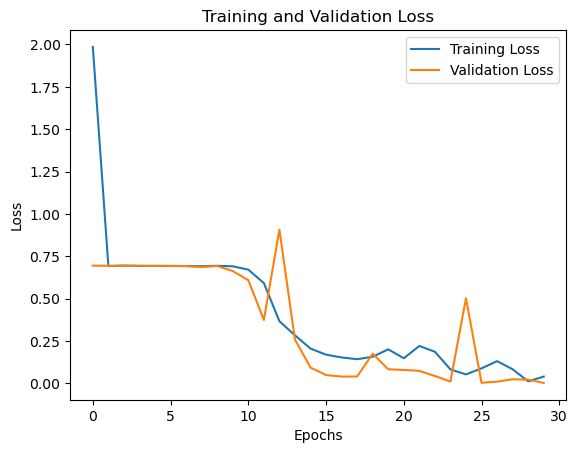

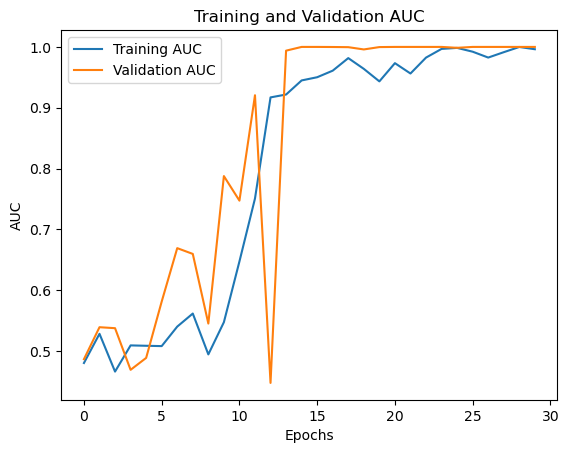

In [41]:
import matplotlib.pyplot as plt

# get the best estimator
best_estimator = grid_result.best_estimator_
#print(best_estimator.history)

# get training and validation loss and AUC
train_loss = best_estimator.history[:, 'train_loss']
val_loss = best_estimator.history[:, 'valid_loss']
train_auc = best_estimator.history[:, 'train_auc']
val_auc = best_estimator.history[:, 'valid_auc']

# plot the training and validation loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# plot the training and validation AUC curves
plt.figure()
plt.plot(train_auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')

In [42]:
best_estimator = grid_result.best_estimator_
print(best_estimator)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (conv_layers): Sequential(
      (0): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): MaxPool1d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (conv1): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
    (pool1): MaxPool1d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=4088, out_features=50, bias=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (fc2): Linear(in_features=50, out_features=50, bias=True)
    (dropout2): Dropout(p=0.1, inplace=False)
    (fc3): Linear(in_features=50, out_features=50, bias=True)
    (dropout3): Dropout(p=0.1, inplace=False)
    (fc4): Linear(in_features=50, out_features=50, bias=True)
    (dropout4): Dropout(p=0.1, inplace=False)
    (fc5): Linear(in_features=50, out_features=50, bias=True)
    (dropout5): Dropout(p=0.0, inplace=False)
    (fc6): Linear(in_features=

In [43]:
best_model = grid_result.best_estimator_.module_
# Save the best model to HDF5 format
torch.save(best_model.state_dict(), 'best_mirna_expression_model.h5')

In [44]:
# Evaluate performance on test set
y_pred = best_model(test_set_final.to("cuda"))
auc = roc_auc_score(test_labels_final, y_pred.detach().cpu().numpy())

print(auc)

1.0


In [9]:
import torch
import shap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.cat((train_set_final, val_set_final), axis=0).to(device)

class Net(nn.Module):
    def __init__(self, input_size=1534, conv_num_filters=8, conv_kernel_size=5, conv_padding=2, conv_activation=nn.ReLU, pool_kernel_size=4, pool_stride=3, hidden_size=50, output_size=1, num_hidden_layers=6, hidden_activation=torch.nn.functional.gelu, weight_init_conv=init.xavier_normal_, weight_init_hidden=init.xavier_normal_, weight_init_out=init.kaiming_uniform_, dropout_rate1=0.1, dropout_rate2=0.1, dropout_rate3=0.1, dropout_rate4=0.1, dropout_rate5=0.0, dropout_rate6=0.1, weight_constraint=1.0, alpha_l1=0.0, alpha_l2=2.0, batch_size=20):
        super(Net, self).__init__()
        
        self.batch_size = batch_size
        self.conv_num_filters = conv_num_filters
        self.conv_kernel_size = conv_kernel_size
        self.conv_padding = conv_padding
        self.batch_size = batch_size
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride
        self.output_size = 1
        
        # Define the convolutional and max pooling layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=conv_padding),
            nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        )
        
        # Generate some random input
        z = torch.randn(1, 1534)
        
        # Pass the input through the convolutional layers
        conv_out = self.conv_layers(z)
        #print(conv_out.shape)

        # Calculate the number of features in the output of the last convolutional layer
        fc1_in_size = torch.flatten(conv_out, start_dim = 0, end_dim = 1).shape[0]
        self.fc1_in_size = fc1_in_size
        #print("fc1 in size:")
        #print(fc1_in_size)
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=self.conv_padding)
        self.pool1 = nn.MaxPool1d(kernel_size=pool_kernel_size, stride=pool_stride)
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(self.fc1_in_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate1)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate2)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.dropout3 = nn.Dropout(dropout_rate3)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.dropout4 = nn.Dropout(dropout_rate4)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.dropout5 = nn.Dropout(dropout_rate5)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.dropout6 = nn.Dropout(dropout_rate6)
        self.fc7 = nn.Linear(hidden_size, self.output_size)
        self.weight_constraint = weight_constraint
        
        self.conv_activation = conv_activation()
        #self.hidden_activation = hidden_activation()
        
        # Manually init weights
        weight_init_conv(self.conv1.weight)
        weight_init_hidden(self.fc1.weight)
        weight_init_hidden(self.fc2.weight)
        weight_init_hidden(self.fc3.weight)
        weight_init_hidden(self.fc4.weight)
        weight_init_hidden(self.fc5.weight)
        weight_init_hidden(self.fc6.weight)
        weight_init_out(self.fc7.weight)
    
    def forward(self, x):
        batch_size = x.shape[0]
        out = []
        for i in range(batch_size):
            x_batch = x[i].unsqueeze(0)
            x_batch = self.conv_activation(self.conv1(x_batch))
            x_batch = self.pool1(x_batch)
            #print(x_batch.shape)
            x_batch = torch.flatten(x_batch, start_dim = 0, end_dim = 1)
            #print("x_batch shape:")
            #print(x_batch.shape)
            x_batch = torch.nn.functional.gelu(self.fc1(x_batch))
            x_batch = self.dropout1(x_batch)
            x_batch = torch.nn.functional.gelu(self.fc2(x_batch))
            x_batch = self.dropout2(x_batch)
            x_batch = torch.nn.functional.gelu(self.fc3(x_batch))
            x_batch = self.dropout3(x_batch)
            x_batch = torch.nn.functional.gelu(self.fc4(x_batch))
            x_batch = self.dropout4(x_batch)
            x_batch = torch.nn.functional.gelu(self.fc5(x_batch))
            x_batch = self.dropout5(x_batch)
            x_batch = torch.nn.functional.gelu(self.fc6(x_batch))
            x_batch = self.dropout6(x_batch)
            x_batch = torch.sigmoid(self.fc7(x_batch))
            out.append(x_batch.view(-1, 1))
        return torch.stack(out, dim=0)

model = Net().to("cpu")
model.load_state_dict(torch.load('best_mirna_expression_model.h5', map_location=device))

X = X.to("cpu")
test_set_final = test_set_final.to("cpu")

explainer = shap.DeepExplainer(model, X)

# shap_values = explainer.shap_values(test_set_final)
#y_pred = model(test_set_final.to(device))
# auc = roc_auc_score(test_labels_final, y_pred.detach().cpu().numpy())

# print(auc)
#print(y_pred.shape)
#print(test_set_final.shape)
#print(X.shape)

In [10]:
shap_values = explainer.shap_values(test_set_final)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


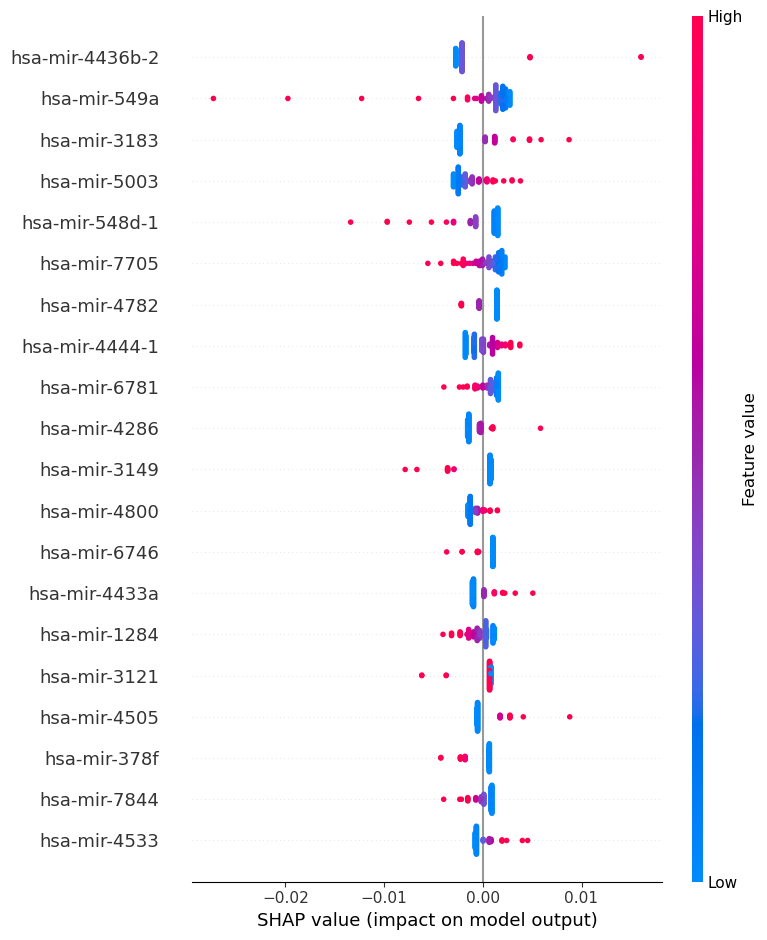

In [11]:
feature_names = mirna_file.iloc[:,1:].columns.values.tolist()

shap.summary_plot(shap_values, test_set_final, feature_names = feature_names)

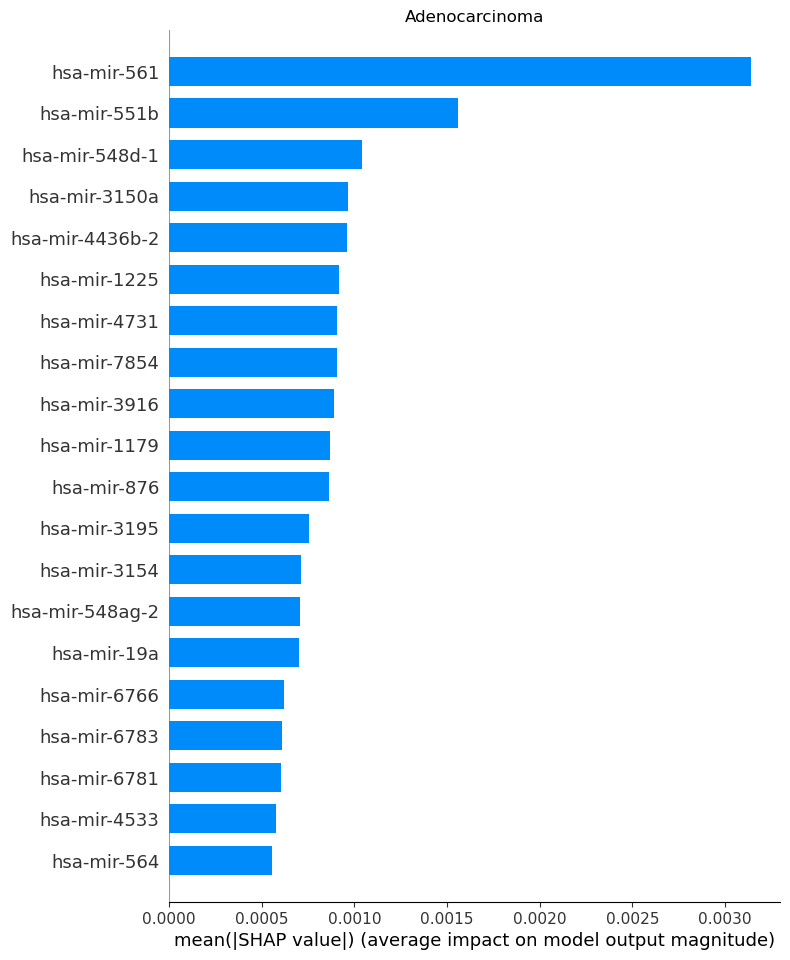

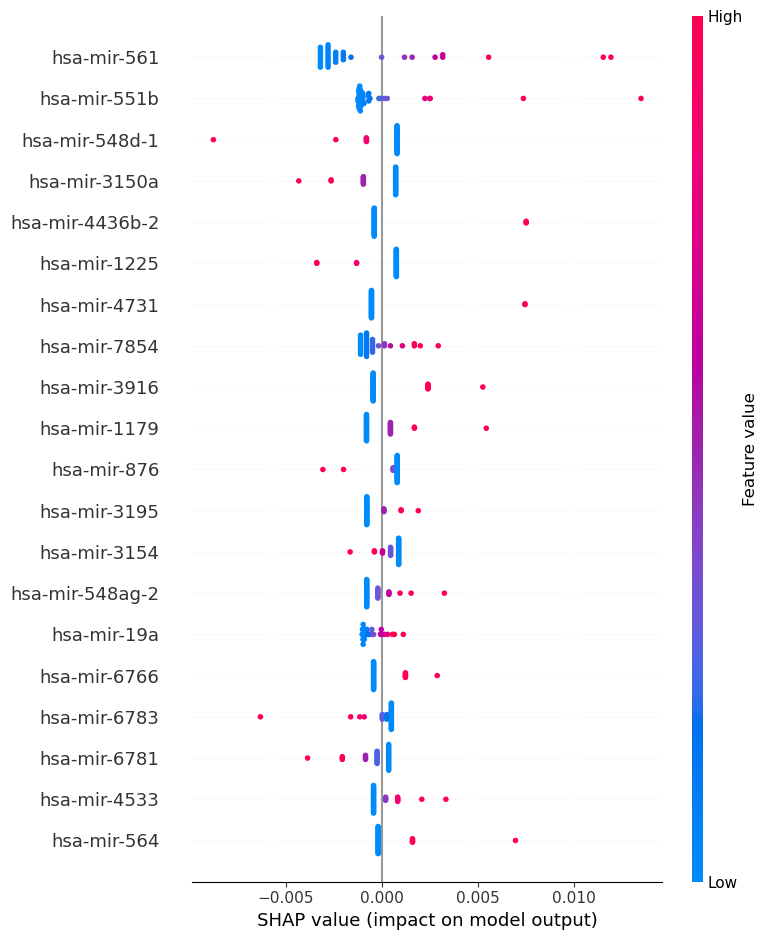

In [12]:
#Adenocarcinoma
# filter instances with label 0
label_0_instances = test_set_final[test_labels_final == 0].to("cpu")

# create explainer for label 0 instances
explainer_0 = shap.DeepExplainer(model, label_0_instances)

# calculate shap values for label 0 instances
shap_values_0 = explainer_0.shap_values(label_0_instances)

# create shap summary plot for label 0 instances
#shap.summary_plot(shap_values_0, label_0_instances, feature_names=exp_file.columns[1:], plot_type='bar', show=False)

# create first plot
fig, ax = plt.subplots()
shap.summary_plot(shap_values_0, label_0_instances, feature_names=mirna_file.columns[1:], plot_type='bar', show=False)
ax.set_title("Adenocarcinoma")

# create second plot
fig2, ax2 = plt.subplots()
shap.summary_plot(shap_values_0, label_0_instances, feature_names=mirna_file.columns[1:], color_bar=True)
ax2.set_title("Adenocarcinoma")

# display the two plots side by side
plt.show()

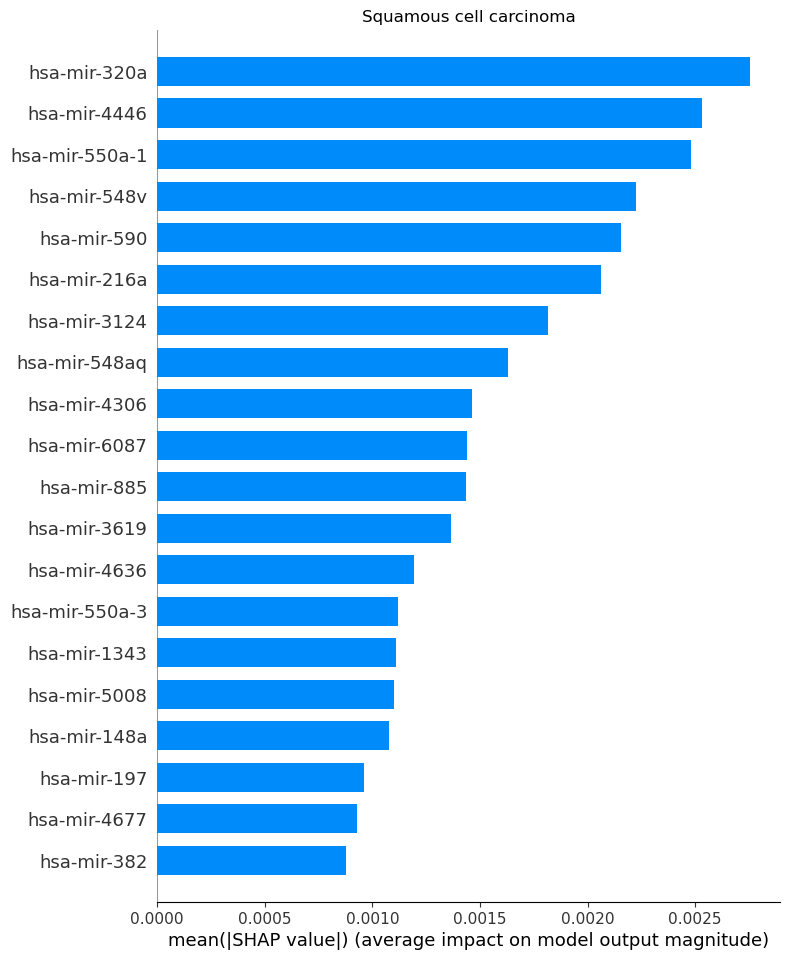

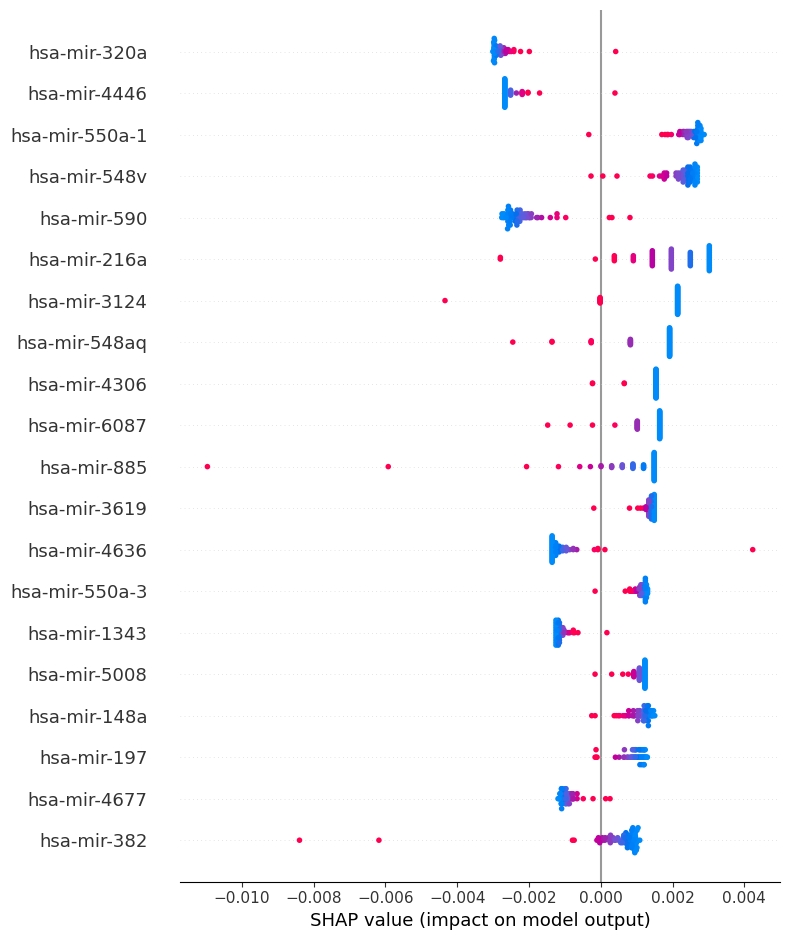

In [13]:
#Squamous cell carcinoma (SCC)
# filter instances with label 1
label_1_instances = test_set_final[test_labels_final == 1].to("cpu")

# create explainer for label 1 instances
explainer_1 = shap.DeepExplainer(model, label_1_instances)

# calculate shap values for label 0 instances
shap_values_1 = explainer_1.shap_values(label_1_instances)

# create first plot
fig, ax = plt.subplots()
shap.summary_plot(shap_values_1, label_1_instances, feature_names=mirna_file.columns[1:], plot_type='bar', show=False)
ax.set_title("Squamous cell carcinoma")

# create second plot
fig2, ax2 = plt.subplots()
shap.summary_plot(shap_values_1, label_1_instances, feature_names=mirna_file.columns[1:], color_bar=False)
ax2.set_title("Squamous cell carcinoma")

# display the two plots side by side
plt.show()

In [14]:
import numpy as np

# Compute the mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)

# Print the feature importances in descending order
sorted_idx = np.argsort(mean_shap_values)[::-1]
#for i in sorted_idx:
#    print(f"{feature_names[i]}: {mean_shap_values[i]:.3f}")

In [15]:
#Calculating variance explained
# Convert data to CPU
X = X.to("cpu")
test_set_final = test_set_final.to("cpu")

# Create the explainer
explainer = shap.DeepExplainer(model, X)

# Compute SHAP values
shap_values = explainer.shap_values(test_set_final)

# Calculate TSS
y_test = model(test_set_final.to("cpu"))
tss = np.var(y_test.detach().cpu().numpy()) * (len(y_test) - 1)

# Calculate ESS
ess = np.sum(np.square(shap_values))

# Calculate percent variance explained
percent_variance_explained = (ess / tss) * 100

In [ ]:
percent_variance_explained

0.044565218976499885

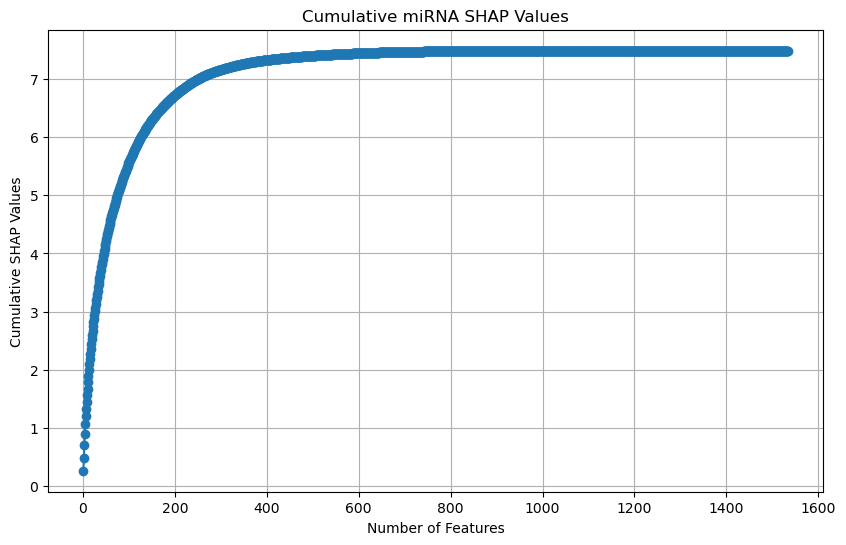

In [ ]:
#Plotting cumulative SHAP values
abs_shap_values = np.abs(shap_values)
sum_shap_values = np.sum(abs_shap_values, axis=0)
sorted_sum_shap_values = np.sort(sum_shap_values)[::-1]
cumulative_sum = np.cumsum(sorted_sum_shap_values)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_sum) + 1), cumulative_sum, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative SHAP Values')
plt.title('Cumulative miRNA SHAP Values')
plt.grid(True)
plt.show()

In [ ]:
# If shap_values is a list, convert it to numpy array
shap_values = np.array(shap_values)

# Calculate mean absolute SHAP values for each feature
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

# Sort features by descending mean absolute SHAP value
sorted_indices = np.argsort(mean_abs_shap)[::-1]
sorted_values = mean_abs_shap[sorted_indices]

# Accumulate until 95% of the total explainability
cumulative_explainability = np.cumsum(sorted_values) / np.sum(sorted_values)
features_95_percent = np.where(cumulative_explainability <= 0.95)[0]

# Get indices of top features
top_feature_indices = sorted_indices[features_95_percent]

print("Indices of features accounting for 95% of the explainability:")
print(top_feature_indices)
len(top_feature_indices) / X.shape[1]


Indices of features accounting for 95% of the explainability:
[ 614 1060  371  912 1039 1460  866  620 1309  577  335  884 1269  607
  101  308  670  512 1463  700  684 1076 1200 1041 1479  598  557 1019
 1426  339 1411 1338 1313  762  550  604  843 1497  329 1294  599   53
 1340  613 1013 1027 1072 1196 1147  482  916  312  855 1225 1046  711
  729  856   92  811  879 1412   57 1385 1048  791  542  716  226 1271
 1149 1209  365 1435  757 1140 1315  817  804 1445  761  166  553  783
 1366  852 1394 1440 1324 1291  362 1265  806  593  677  384  678  240
  494  449  834  730 1364 1124 1162  439 1166 1323 1381 1252  610  779
  323 1104  370  833 1158 1416  909  849 1397 1310  660  141 1009 1241
 1122 1210 1059  472 1035  348  887  697  943 1413  911  828  320   69
   62 1382  332  853 1057 1266 1457 1282 1403  877 1167  649   25  788
  631  832  526 1087 1319  865  393 1264 1254 1522 1029 1329  619  794
  654  682 1465 1211 1432  659  938  787  453  368   49  387 1277  540
  725  524  751

0.1831812255541069

In [ ]:
#Output the top features from the training set
top_features_train = pd.DataFrame(X[:,top_feature_indices])
labels_train = mirna_file.columns[:]
top_labels_train = labels_train[top_feature_indices]
sample_names = mirna_file.iloc[:,0]

top_features_train.columns = top_labels_train

#train_output_file = pd.concat([sample_names, top_features_train], axis = 1)
#train_output_file
top_features_train.to_csv("mirna_top_95_pct_shap_features_train.txt", sep = "\t", header = True)

In [ ]:
#Output the top features from the training set
top_features_test = pd.DataFrame(test_set_final[:,top_feature_indices])
labels_test = mirna_file.columns[:]
top_labels_test = labels_test[top_feature_indices]
sample_names = mirna_file.iloc[:,0]

top_features_test.columns = top_labels_test

#train_output_file = pd.concat([sample_names, top_features_train], axis = 1)
#train_output_file
top_features_test.to_csv("mirna_top_95_pct_shap_features_test.txt", sep = "\t", header = True)